# MiVOS label processing

Fixing some stuff that the MiVOS UI isn't good at, and prepping data for ML

In [43]:
import os
import random

import cv2
import matplotlib.pyplot as plt
import numpy as np

from scipy.ndimage.morphology import binary_dilation
from skimage.morphology import label
from sklearn.metrics import jaccard_score

### Load masks, display samples

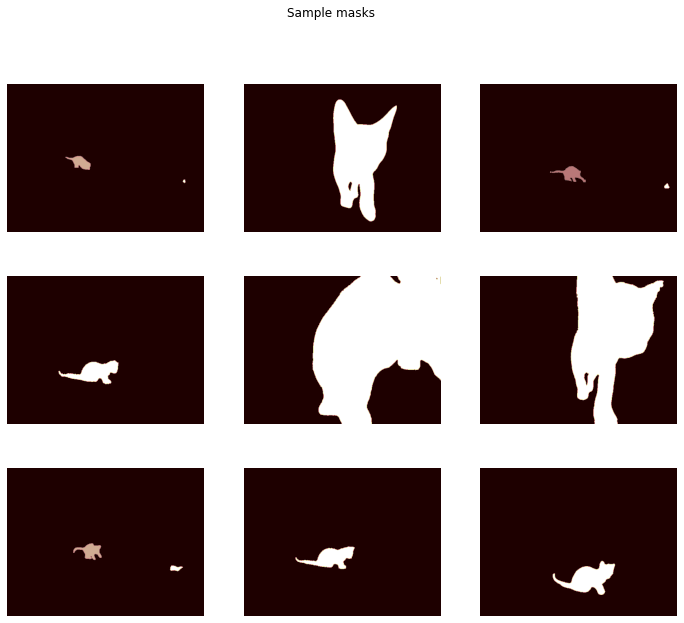

In [27]:
save_dir = './labels/beanlog4_001/mask/'
pngs = sorted([f for f in os.listdir(save_dir) if os.path.splitext(f)[1] == '.png'])
masks = [label(plt.imread(os.path.join(save_dir, f))[..., 0] > 0) for f in pngs]
mask_samples = random.sample(masks, 9)
f, axs = plt.subplots(3, 3, figsize=(12, 10))
for ax, sample in zip(axs.flatten(), mask_samples):
    ax.imshow(sample, cmap='pink')
    ax.axis('off')
f.suptitle('Sample masks')
plt.show()

## Subject-tracking elimination of false-positives

MiVOS liked to falsely label a bunch of blobs that never touch true-positive subject masks. Here's a crude way to get rid of the false-positives: 

    1. Record the location of a point inside the subject mask in frame 1.
    2. Save the mask connected component containing that point in frame 1.
    3. For frames 2-end, save only the mask connected component with highest IoU with the previous frame's subject mask.

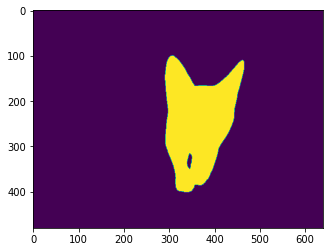

[0.0, 0.9860916239762456, 0.0]
1
[0.9698903391230027, 7.414437392490658e-06]
0
[0.977817817256392, 1.4165008180292224e-05]
0
[0.9746336666574333, 0.0]
0
[0.9771608841480178, 0.0]
0
[0.9607865340678226, 0.0, 0.0, 0.0]
0
[0.9670457259626868, 0.0]
0
[0.0, 0.9827992491313088]
1
[0.9763199682413656, 6.700526661395586e-06]
0
[0.0, 0.9664479261934484]
1
[0.9833956987099203, 0.0]
0
[0.8706327300677801, 0.0]
0
[0.8801045233375383, 0.0]
0
[0.0, 0.938756534858426]
1
[0.9358506025741695, 0.0]
0
[0.9695776311903122, 0.0]
0
[0.8750174686728467, 0.0]
0
[0.7223080317740512, 0.0]
0
[0.6884360290971331, 0.0]
0
[0.0, 0.0, 0.9092438321050945]
2
[0.0, 0.7687972826926046]
1
[0.7983078263033471, 0.0004847309743092584, 0.0004154836922650786, 0.00013849456408835954, 0.0, 6.924728204417977e-05]
0
[0.7883577970141764, 0.0, 0.0]
0
[0.7751909563091964, 0.0, 0.0, 0.0]
0
[0.8384150182688673, 0.0]
0
[0.5550953678474114, 0.0]
0
[0.4508381943349624, 0.0]
0
[0.8906353627802096, 0.0, 0.0]
0
[0.8817499183806725, 0.0002095

In [38]:
first_frame_point = (220, 370)  # (Y, X) order
save_dir = './labels/beanlog4_001/mask_corrected'
os.makedirs(save_dir, exist_ok=True)

prev_mask = masks[0] == masks[0][first_frame_point]
for name, mask in zip(pngs, masks):
    nonzero_labels = [v for v in np.unique(mask) if v != 0]
    if len(nonzero_labels) > 1:
        component_masks = [mask == v for v in nonzero_labels]
        component_ious = [jaccard_score(prev_mask.flatten(), m.flatten()) for m in component_masks]
        best_match_idx = np.argmax(component_ious)
        mask = component_masks[best_match_idx]
    prev_mask[...] = mask[...]
    plt.imsave(os.path.join(save_dir, name), mask, cmap='pink')
        

### Utility functions

For data prep and manipulation

In [44]:
from typing import List, Tuple


def get_frames(path: str, scale: float = 1) -> List[np.ndarray]:
    vid_obj = cv2.VideoCapture(path)
    success = 1
    frames = []
    while success:
        success, frame = vid_obj.read()
        if frame is not None:
            if scale != 1:
                fy, fx = frame.shape[:2]
                fy_new = round(fy * scale)
                fx_new = round(fx * scale)
                frame = cv2.resize(frame, (fx_new, fy_new), interpolation=cv2.INTER_CUBIC)
            frames.append(frame)
    return frames


def video_to_frames(save_dir: str, vid_path: str, scale: float = 1):
    frames = get_frames(vid_path, scale)
    print(f'Found {len(frames)} frames')
    for i, frame in enumerate(frames):
        plt.imsave(os.path.join(save_dir, f'{i:05}.png'), frame)
    return


def ez_video_to_frames(vid_name: str) -> None:
    save_dir = os.path.join('data', 'image', vid_name)
    os.makedirs(save_dir, exist_ok=True)
    vid_idx = int(vid_name.split('_')[0][7:])
    vid_path = os.path.join('raw_data', 'videos', f'{vid_idx:03}', 'clips', f'{vid_name}.mp4')
    video_to_frames(save_dir, vid_path, 2)
    return


def overlay(
        save_dir: str, 
        src_video_file: str, 
        mask_dir: str, 
        scale: float = 2,
        color: Tuple[int, int, int] = (255, 50, 50),
        alpha: float = 0.5) -> None:
    frames = get_frames(src_video_file, scale)
    mask_files = sorted([f for f in os.listdir(mask_dir) if '.png' in f])
    masks = [(plt.imread(os.path.join(mask_dir, f))[..., 0] > 0.95).astype(int) for f in mask_files]
    assert len(frames) == len(masks), f'Found {len(frames)} frames and {len(masks)} masks'
    
    color_map = [
        [0, 0, 0], 
        [255, 50, 50], 
        [50, 255, 50], 
        [50, 50, 255], 
        [255, 50, 255], 
        [50, 255, 255], 
        [255, 255, 50], 
    ]

    color_map_np = np.array(color_map)
    os.makedirs(save_dir, exist_ok=True)
    for file, mask, frame in zip(mask_files, masks, frames):
        im_overlay = frame.copy()
        if im_overlay.ndim == 2:
            im_overlay = np.expand_dims(im_overlay, 2)
        if im_overlay.shape[2] == 1:
            im_overlay = np.concatenate((im_overlay,)*3, axis=2)
        colored_mask = color_map_np[mask]
        foreground = frame * alpha + (1 - alpha) * colored_mask
        binary_mask = mask > 0
        im_overlay[binary_mask] = foreground[binary_mask]
        contours = binary_dilation(binary_mask) ^ binary_mask
        im_overlay[contours] = 0
        plt.imsave(os.path.join(save_dir, file), im_overlay.astype(frame.dtype))
    return
        
    

---

# Video manipulation sandbox

---

Temporary and transient cells for editing video and image content

In [42]:
ez_video_to_frames('beanlog4_001')

Found 433 frames


In [30]:
overlay(
    './labels/beanlog4_001/overlay', 
    './BeanLogs/Bean Log 4/clips/beanlog4_001.mp4', 
    './labels/beanlog4_001/mask_corrected/')